# Detection of cracks in concrete structures
### imports

In [126]:
import os; 
os.environ['CUDA_VISIBLE_DEVICES']="0"
from fastai2.vision.all import *
from fastai2.basics import *
from fastai2.callback.progress import *
from fastai2.vision.core import *
from fastai2.callback import mixup

from fastai2.imports import *
from fastai2.torch_core import *
from fastai2.learner import *
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
import cv2
import shutil


torch.cuda.empty_cache() 

### Helper functions for test data. 

In [22]:
def plot_confusion_matrix(y_true, y_pred):
#     lab = ['Normal', 'Bacterial', 'Viral', 'COVID-19']
    data = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(data, columns=np.unique(y_true), index=np.unique(y_true))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize=(12, 12))
    sns.set(font_scale=1.0)  # for label size
    sns.heatmap(df_cm, cmap="Blues", annot=True, fmt='d', annot_kws={"size": 9}, cbar=False)
    plt.xticks(rotation=90)  # font size
    plt.yticks(rotation=0)  # font size
    plt.subplots_adjust(bottom=0.4)
    plt.subplots_adjust(left=0.4)


In [ ]:
def test_function(learn, labels_dict):
    
    
    test_path = Path('data/test')
    imgs = get_image_files(test_path)
    
    test_dl = learn.dls.test_dl
    dl = test_dl(imgs, labels=True)

    a,b,preds = learn.get_preds(dl=dl, with_decoded=True)
    
    labels = [str(x).split('/')[-2] for x in imgs]
    predictions = [labels_dict[i] for i in preds.tolist()]

    data = {'y_Actual':    labels,
            'y_Predicted': predictions
            }
    print(classification_report(labels,predictions))

    plot_confusion_matrix(labels,predictions)
    
    print(np.sum(np.array(labels)==np.array(predictions))/len(predictions))

### download data 
- link: https://data.mendeley.com/datasets/5y9wdsg2zt/2
- create a folder called train and extract the files there.

In [23]:
path = Path('data')

In [24]:
path.ls()

(#2) [Path('data/train'),Path('data/test')]

In [25]:
print(f"Number of cracked images: {len(os.listdir(path/'train/Positive'))}")
print(f"Number of non-cracked images: {len(os.listdir(path/'train/Negative'))}")

Number of cracked images: 20000
Number of non-cracked images: 20000


In [26]:
Path('data/test/Positive').mkdir(parents=True, exist_ok=True)
Path('data/test/Negative').mkdir(parents=True, exist_ok=True)

In [27]:
def randomly_move_n_files(source_folder, destination_folder, pct=0.15):
    """
    randomly select files from the source folder and move to destination folder
    """
    n = int(len(os.listdir(source_folder))*pct)
    files = random.sample(os.listdir(source_folder),n)
    for f in files:
        shutil.move(os.path.join(source_folder,f), destination_folder)

In [30]:
print(f"Train: Number of cracked images: {len(os.listdir(path/'train'/'Positive'))}")
print(f"Train: Number of non-cracked images: {len(os.listdir(path/'train'/'Negative'))}")

Train: Number of cracked images: 20000
Train: Number of non-cracked images: 20000


In [31]:
print(f"Test: Number of cracked images: {len(os.listdir(path/'test'/'Positive'))}")
print(f"Test: Number of non-cracked images: {len(os.listdir(path/'test'/'Negative'))}")

Test: Number of cracked images: 0
Test: Number of non-cracked images: 0


In [32]:
# run this if you freshly downloaded the data and want to randomly create test data
# randomly_move_n_files(source_folder=path/'train'/'Positive', destination_folder=path/'test'/'Positive', pct=0.15)
# randomly_move_n_files(source_folder=path/'train'/'Negative', destination_folder=path/'test'/'Negative', pct=0.15)

In [33]:
print(f"Train: Number of cracked images: {len(os.listdir(path/'train'/'Positive'))}")
print(f"Train: Number of non-cracked images: {len(os.listdir(path/'train'/'Negative'))}")
print(f"Test: Number of cracked images: {len(os.listdir(path/'test'/'Positive'))}")
print(f"Test: Number of non-cracked images: {len(os.listdir(path/'test'/'Negative'))}")

Train: Number of cracked images: 17000
Train: Number of non-cracked images: 17000
Test: Number of cracked images: 3000
Test: Number of non-cracked images: 3000


### Data loader and data augmentation. 

In [34]:
def get_dataloader(path, batch_size, resize_image, image_size):
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                        get_items=get_image_files, 
                        get_y=parent_label, 
                        splitter=RandomSplitter(valid_pct=0.2, seed=42), 
                        item_tfms=Resize(resize_image), 
                        batch_tfms=[*aug_transforms(do_flip=True, 
                                                    flip_vert=True, 
                                                    max_rotate=10, 
                                                    max_zoom=1.1, 
                                                    max_lighting=0.2,
                                                    min_scale=0.75,
                                                    size=image_size), 
                                                    Normalize.from_stats(*imagenet_stats)]
                        )
    return dblock.dataloaders(path, bs=batch_size)

In [82]:
# create image dataloader. 
image_dataloader = get_dataloader(path, 128, 227, 224)

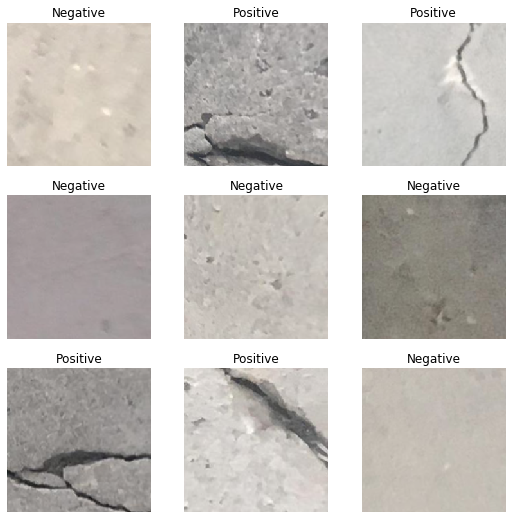

In [83]:
image_dataloader.show_batch(max_n=9)

### Create CNN model using pretrained ResNet34 with imagenet weights

In [84]:
learn=cnn_learner(image_dataloader, resnet34, metrics=[error_rate, accuracy])

In [85]:
learn.summary()

Sequential (Input shape: ['128 x 3 x 224 x 224'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               128 x 64 x 112 x 11  9,408      False     
________________________________________________________________
BatchNorm2d          128 x 64 x 112 x 11  128        True      
________________________________________________________________
ReLU                 128 x 64 x 112 x 11  0          False     
________________________________________________________________
MaxPool2d            128 x 64 x 56 x 56   0          False     
________________________________________________________________
Conv2d               128 x 64 x 56 x 56   36,864     False     
________________________________________________________________
BatchNorm2d          128 x 64 x 56 x 56   128        True      
________________________________________________________________
ReLU                 128 x 64 x 56 x 56   0          False     
________________________________________________

### Find the best learning rate

(0.03630780577659607, 0.0003981071640737355)

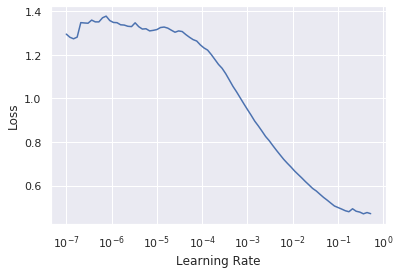

In [86]:
learn.lr_find()

In [87]:
learn.fit_one_cycle(5, lr_max=1e-3)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.029267,0.009076,0.003125,0.996875,01:11
1,0.007776,0.006099,0.001750,0.998250,01:10
2,0.008282,0.007021,0.002000,0.998000,01:11
3,0.008966,0.004695,0.001250,0.998750,01:11
4,0.003836,0.003800,0.001250,0.998750,01:11


### Results on validation set. 

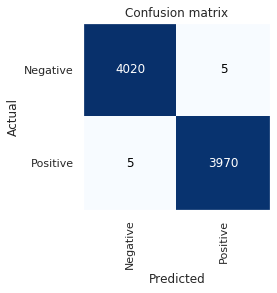

In [89]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

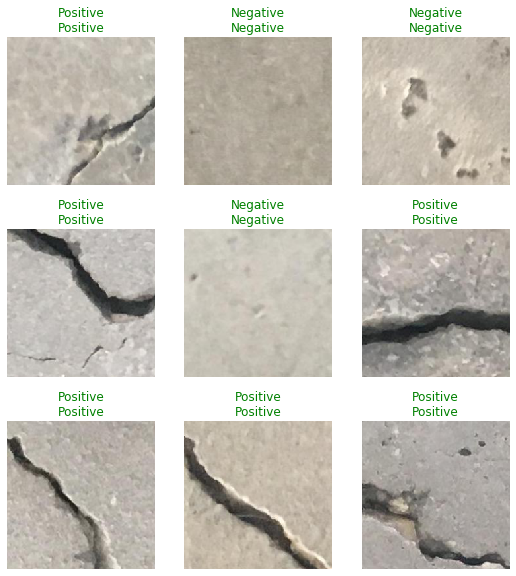

In [90]:
learn.show_results()

(2.5118865210060903e-08, 3.019951861915615e-07)

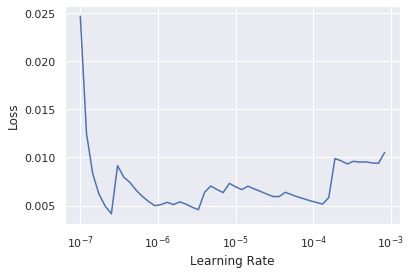

In [67]:
learn.unfreeze()
learn.lr_find()

In [69]:
learn.fit_one_cycle(3, lr_max=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.006149,0.004709,0.001125,0.998875,00:26
1,0.006483,0.005065,0.001250,0.998750,00:26
2,0.003662,0.004665,0.001250,0.998750,00:27


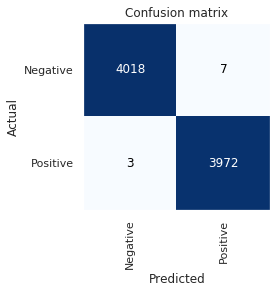

In [70]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

### check all the misclassifications

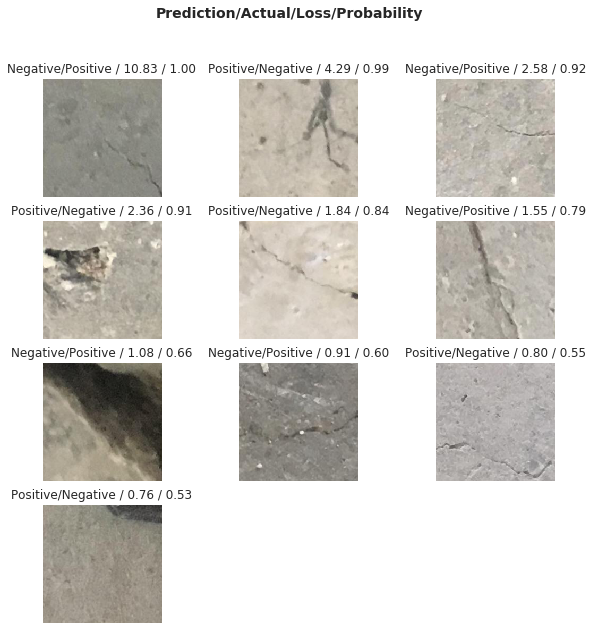

In [122]:
interp.plot_top_losses(10, figsize=(10,10))

In [91]:
label_dict = {}
for k, v in enumerate(image_dataloader.vocab):
    label_dict[k] = v
label_dict

{0: 'Negative', 1: 'Positive'}

## Independent test set

              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00      3000
    Positive       1.00      1.00      1.00      3000

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000

0.9995


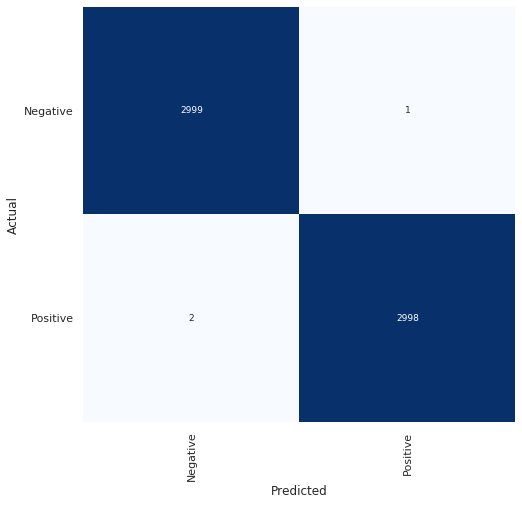

In [92]:
test_function(learn, label_dict)

## Prediction on a bigger image
Predcition on a larger image is done by diving the image into smaller patches and then doing prediction on each patch. Patches smaller than 128x128 are discarded. Patches are stiched together and prediction is overlayed on top of it. Red color shows cracks. This function is adopted [from](https://github.com/priya-dwivedi/Deep-Learning/blob/master/crack_detection/Crack%20Detection%20Model.ipynb) 

In [119]:
def predict_on_whole_image(im, height=128, width=128):
    '''
    divided input images to regions of the (height, width). Any segments that are left 
    are discarded and not used for prediction. 
    
    '''
    imgheight, imgwidth, channels = im.shape
    print(imgheightght, imgwidth, channels)
    k=0
    output_image = np.zeros_like(im)
    for i in range(0,imgheight,height):
        for j in range(0,imgwidth,width):
            a = im[i:i+height, j:j+width]
            ## discard image cropss that are not full size
            predicted_class = learn.predict(a)[0]

            if predicted_class == 'Positive':
                color = (255, 0, 0)
            else:
                color = (255, 255, 255)
            b = np.zeros_like(a, dtype=np.uint8)
            b[:] = color
            add_img = cv2.addWeighted(a, 0.8, b, 0.2, 0)
            output_image[i:i+height, j:j+width,:] = add_img
            k+=1

    return output_image


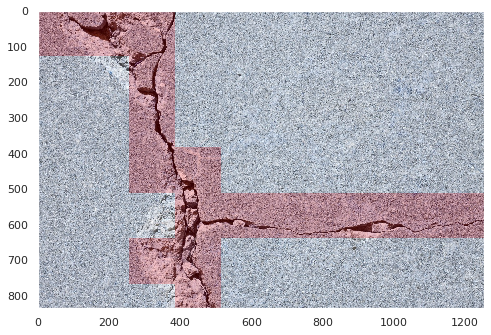

In [132]:
image_file = "concrete_crack3.jpeg"
im = cv2.imread(f"test_images/{image_file}")
output_image = predict_on_whole_image(im)
plt.imsave(f"test_images/output_{image_file}", output_image)

plt.figure(figsize=(8,20))
plt.imshow(output_image)
plt.grid(False)

In [111]:
output_image.shape

(750, 1000, 3)

In [112]:
os.getcwd()

'/home/phyn/Deep Learning Projects'

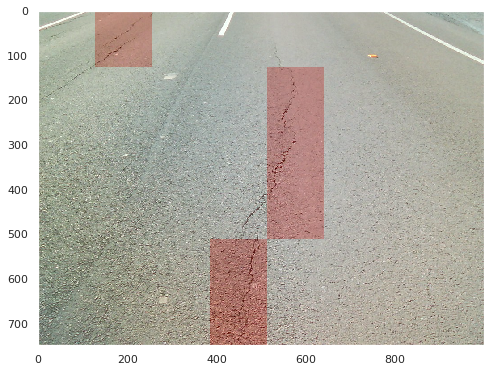

In [65]:
# learn.recorder.plot_metrics()

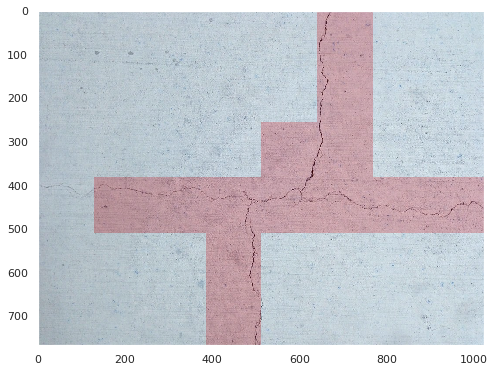

In [101]:
plt.figure(figsize=(8,20))
plt.imshow(output_image)
plt.grid(False)